# Person Segmentation Netowork

### Import necessary python lib

- set ImageFile.LOAD_TRUNCATED_IMAGES = True to avoid warinings while training. 
- data module contains all the image generator module functions for training

In [1]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import segmentation_models as sm
import sys
sys.path.append("..")
from seg_net.data import *
from seg_net.MMNet import MMNet, custom_loss
import keras

Using TensorFlow backend.
/home/avantariml/.local/lib/python3.5/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


## Set Model Params

In [2]:
INPUT_SHAPE =  (256,256,3) #(768,768,3) (512,512,3) (256,256,3)
NUM_CLASS = 1
BACKBONE = 'O'
MODEL_NAME = 'MMNet'
LOSS_METRICS = 'CUS_ACC_IOU'
ACTIVATION = 'sigmoid'
DATASET = "train_person"
IMGNORM = 'divide'
MODEL_PATH = '../results/Models/MMNet'
NUM_TRAIN = len(os.listdir('../data/raw/train/{}/images'.format(DATASET)))
BATCH_SIZE = 32

model_fname = '{0}_{1}_{2}_{3}_{4}_{5}_{6}_{7}'.format(BACKBONE,
                                                MODEL_NAME,
                                                LOSS_METRICS,
                                                IMGNORM,
                                                NUM_CLASS,
                                                ACTIVATION,
                                                INPUT_SHAPE[0],
                                                DATASET)
keras_filename = '{}.hdf5'.format(model_fname)

print(keras_filename)

pretrained = None
#pretrained = '/media/new_hdd2/seg_net/results/Models/MMNet/O_MMNet_CUS_ACC_IOU_divide_1_sigmoid_128_train_person_G.hdf5'

O_MMNet_CUS_ACC_IOU_divide_1_sigmoid_256_train_person.hdf5


## Build Model

In [3]:
model, endpoints = MMNet(pretrained = pretrained,
                         input_shape = INPUT_SHAPE,
                         input_tensor=None,
                         classes = NUM_CLASS,
                         depth_multiplier = 1.0,
                         activation = ACTIVATION)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
#model.compile('sgd', loss=sm.losses.bce_dice_loss, metrics=['accuracy',sm.metrics.iou_score])
#model.compile('Adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile('sgd', loss='mean_squared_error', metrics=['accuracy',sm.metrics.iou_score])
model.compile('sgd', loss=custom_loss(model.input,endpoints['aux_block']), metrics=['accuracy',sm.metrics.iou_score])

Instructions for updating:
Use tf.cast instead.


In [5]:
#model.load_weights(os.path.join(MODEL_PATH,keras_filename), by_name = True, skip_mismatch = True)
print("Loading from ",os.path.join(MODEL_PATH,keras_filename))

Loading from  ../results/Models/MMNet/O_MMNet_CUS_ACC_IOU_divide_1_sigmoid_256_train_person.hdf5


In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
init_block_pointwise_conv (Conv (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
init_block_pointwise_Relu6 (ReL (None, 128, 128, 32) 0           init_block_pointwise_conv[0][0]  
__________________________________________________________________________________________________
enc_block1_branch_0_pointwise_c (None, 128, 128, 16) 512         init_block_pointwise_Relu6[0][0] 
__________________________________________________________________________________________________
enc_block1

__________________________________________________________________________________________________
enc_block10_merge_pointwise_con (None, 16, 16, 80)   19200       concatenate_10[0][0]             
__________________________________________________________________________________________________
dec_block0refine_depthwise (Dep (None, 32, 32, 40)   360         enc_block5_merge_pointwise_BN[0][
__________________________________________________________________________________________________
enc_block10_merge_pointwise_BN  (None, 16, 16, 80)   320         enc_block10_merge_pointwise_conv[
__________________________________________________________________________________________________
dec_block0refine_depthwise_BN ( (None, 32, 32, 40)   160         dec_block0refine_depthwise[0][0] 
__________________________________________________________________________________________________
dec_block0_pointwise_conv (Conv (None, 16, 16, 64)   5120        enc_block10_merge_pointwise_BN[0]
__________

### Create Train and validation Image generators , keras callbacks to save model, learning rate scheduler and tensorboard monitoring.

In [7]:
data_gen_args = dict(rotation_range=15,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=[1,1.15],
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(BATCH_SIZE,'../data/raw/train/{}'.format(DATASET),'images','annotations',
                        data_gen_args,save_to_dir = None,
                        target_size = INPUT_SHAPE[:2],
                        imgNorm=IMGNORM , 
                        binary = True if DATASET=='train_person' else False,
                        num_class = NUM_CLASS, 
                        multiclass = True if NUM_CLASS>1 else False,
                        alpha = True if DATASET=='train_matte' else False)
'''
valGene = validationGenerator(BATCH_SIZE,'../data/raw/train/{}'.format(DATASET),'images','annotations',
                            save_to_dir = None,
                            target_size = INPUT_SHAPE[:2],
                            imgNorm=IMGNORM, 
                            binary = True if DATASET=='train_person' else False,
                            num_class = NUM_CLASS, 
                            multiclass = True if NUM_CLASS>1 else False,
                            alpha = True if DATASET=='train_matte' else False)
'''
model_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(MODEL_PATH,keras_filename), 
                                                   monitor='loss',
                                                   verbose=1, 
                                                   save_best_only=True)

#tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./log', histogram_freq=0, write_graph=True, write_images=True)

lr_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)

Found 5711 images belonging to 1 classes.
Found 5711 images belonging to 1 classes.


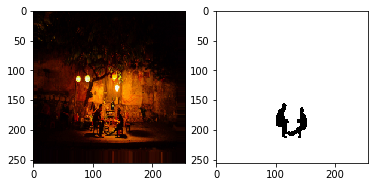

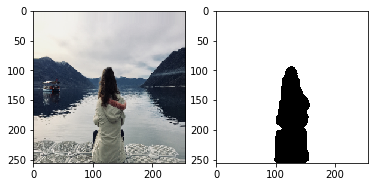

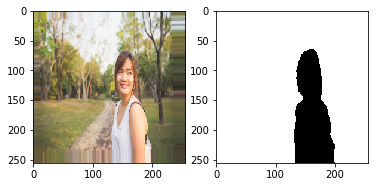

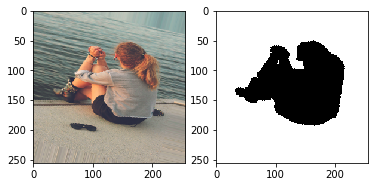

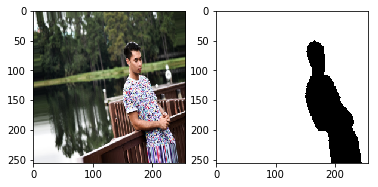

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
for _ in range(5):
    inp,otp = next(myGene)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(inp[0,:,:,:])
    if NUM_CLASS>1:
        axarr[1].imshow(otp.argmax(axis=-1)[0,:,:], cmap='Greys',  interpolation='nearest')
    else:
        axarr[1].imshow(np.squeeze(otp[0]), cmap='Greys',  interpolation='nearest')

## Train Model

In [9]:
model.fit_generator(myGene,steps_per_epoch=NUM_TRAIN/BATCH_SIZE,epochs=300,
                    #validation_data=valGene, validation_steps=100,
                    callbacks=[model_checkpoint,lr_cb],
                    initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
179/178 [==============================] - 516s 3s/step - loss: 1.3331 - acc: 0.6412 - iou_score: 0.1812

Epoch 00001: loss improved from inf to 1.33376, saving model to ../results/Models/MMNet/O_MMNet_CUS_ACC_IOU_divide_1_sigmoid_256_train_person.hdf5
Epoch 2/300
179/178 [==============================] - 467s 3s/step - loss: 1.2134 - acc: 0.6862 - iou_score: 0.1818

Epoch 00002: loss improved from 1.33376 to 1.21389, saving model to ../results/Models/MMNet/O_MMNet_CUS_ACC_IOU_divide_1_sigmoid_256_train_person.hdf5
Epoch 3/300
179/178 [==============================] - 498s 3s/step - loss: 1.1716 - acc: 0.7026 - iou_score: 0.1818

Epoch 00003: loss improved from 1.21389 to 1.17208, saving model to ../results/Models/MMNet/O_MMNet_CUS_ACC_IOU_divide_1_sigmoid_256_train_person.hdf5
Epoch 4/300
179/178 [==============================] - 479s 3s/step - loss: 1.1571 - acc: 0.7132 - iou_score: 0.1869

Epoch 00004: loss improved from

KeyboardInterrupt: 

## Test Model

In [ ]:
import skimage
import glob
import os
import numpy as np
from keras.preprocessing import image
import cv2
path = "../data/raw/test"
fnames = sorted(glob.glob(os.path.join(path,"*.jpg")))
images = []
images_ = []
outs = []
for f in fnames:
    img = skimage.io.imread(f)
    img_ = np.expand_dims(cv2.resize(img,INPUT_SHAPE[:2]),axis=0)
    img_ = preprocess_input(img_, imgNorm=IMGNORM)
    images_.append(img_)
    images.append(img)
    

In [ ]:
%%timeit
_ = model.predict(images_[0])

In [ ]:
%%time
for img_ in images_:
    #outs.append(np.squeeze(model.predict(img_)).argmax(axis=-1))
    outs.append(np.squeeze(model.predict(img_)))

/home/avantariml/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


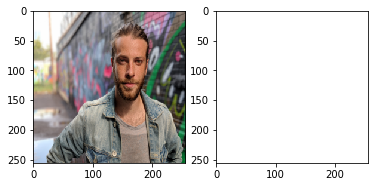

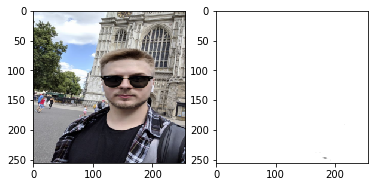

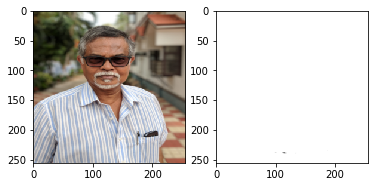

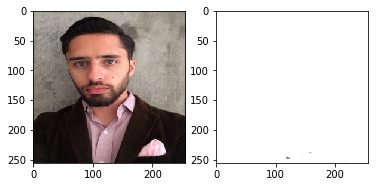

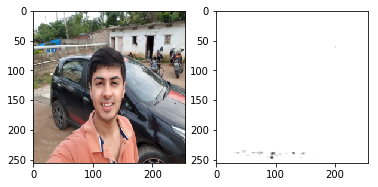

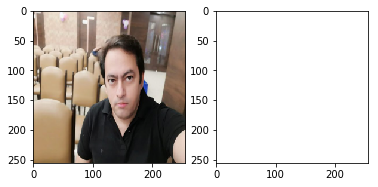

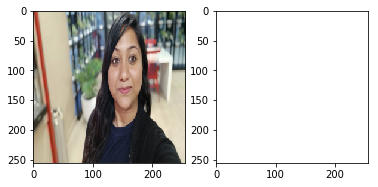

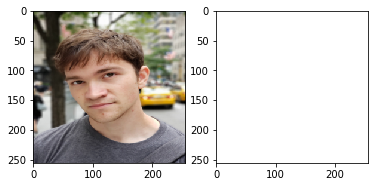

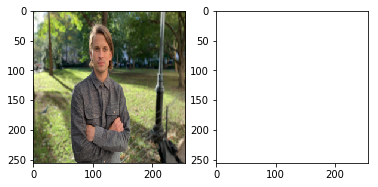

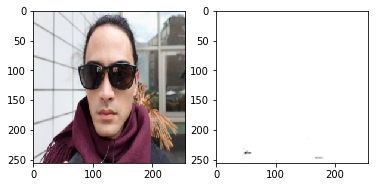

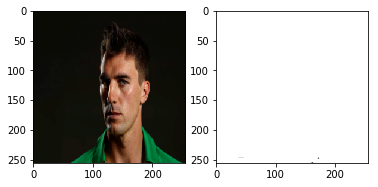

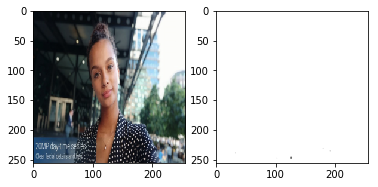

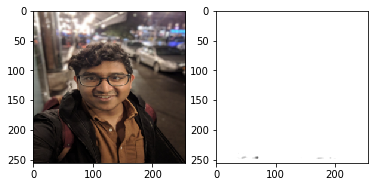

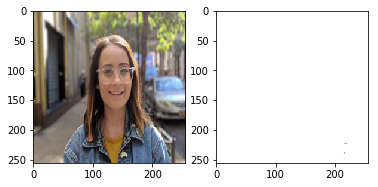

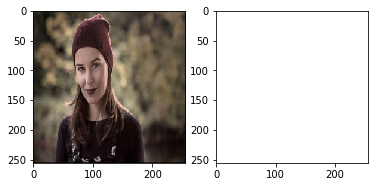

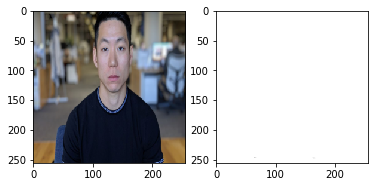

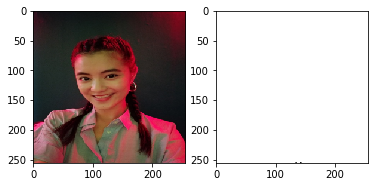

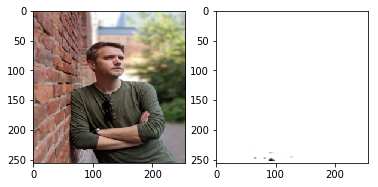

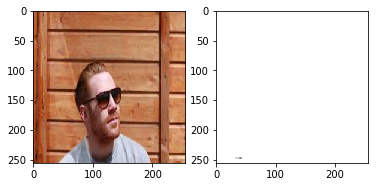

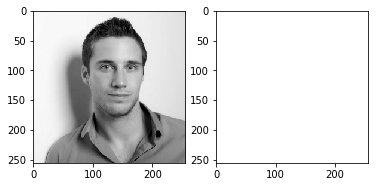

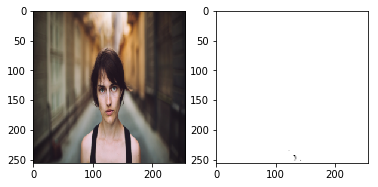

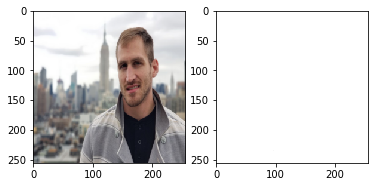

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
for inp,otp in zip(images,outs):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(skimage.transform.resize(inp,INPUT_SHAPE[:2],anti_aliasing=True))
    if NUM_CLASS>1:
        axarr[1].imshow(otp.argmax(axis=-1), cmap='Greys',  interpolation='nearest')
    else:
        axarr[1].imshow(otp*255, cmap='Greys',  interpolation='nearest')

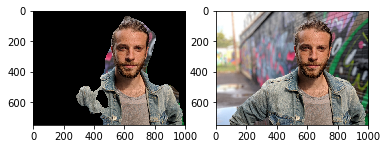

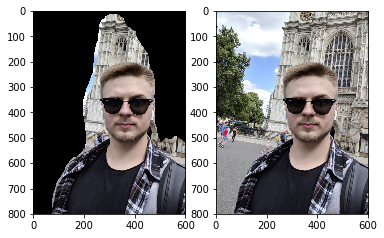

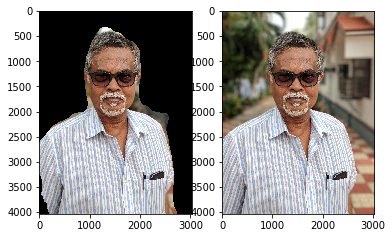

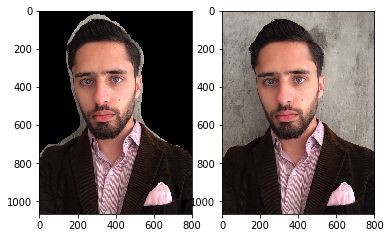

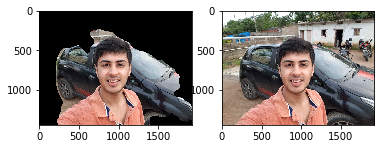

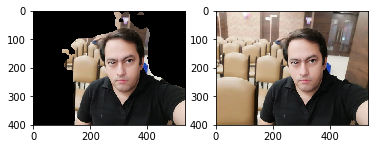

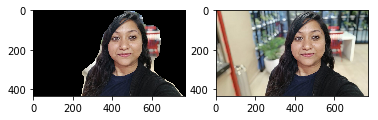

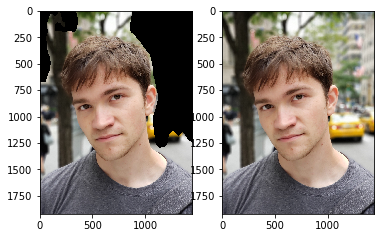

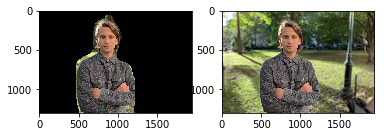

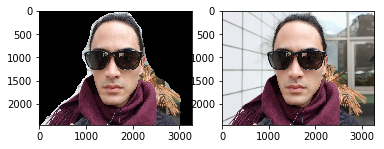

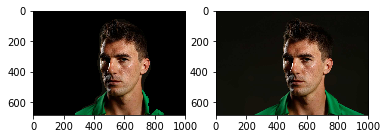

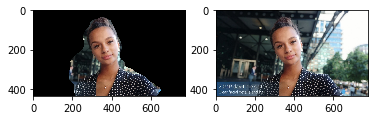

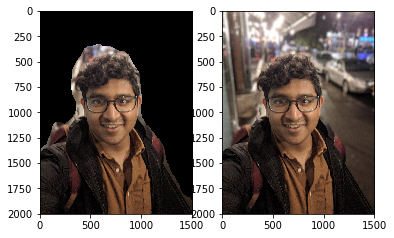

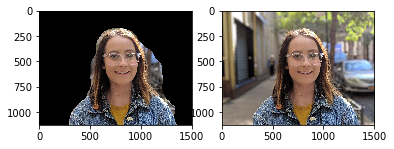

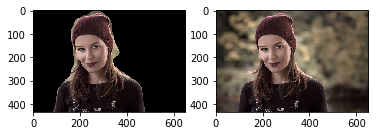

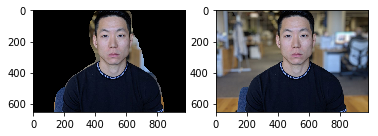

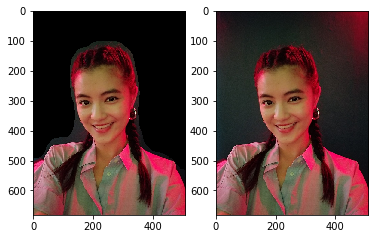

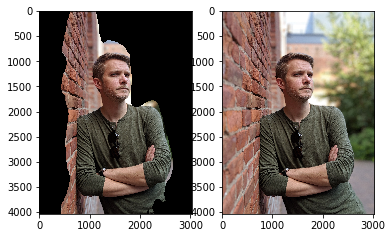

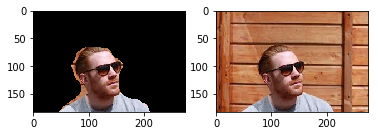

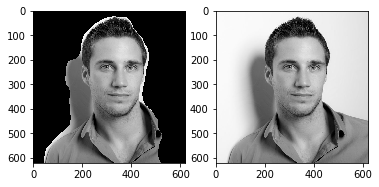

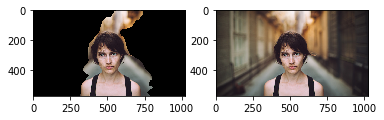

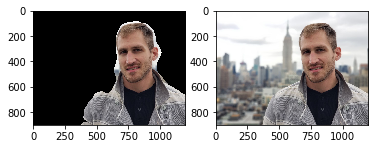

In [35]:
for inp,otp in zip(images,outs):
    mask = skimage.transform.resize(otp,inp.shape[:2],preserve_range=True)
    #mask = cv2.resize(otp,inp.shape[:2])
    im = np.copy(inp)
    #mask[mask>0.1]=1
    im[mask<0.7]=0
    #im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), im.astype(float))/255
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(im)
    axarr[1].imshow(inp)

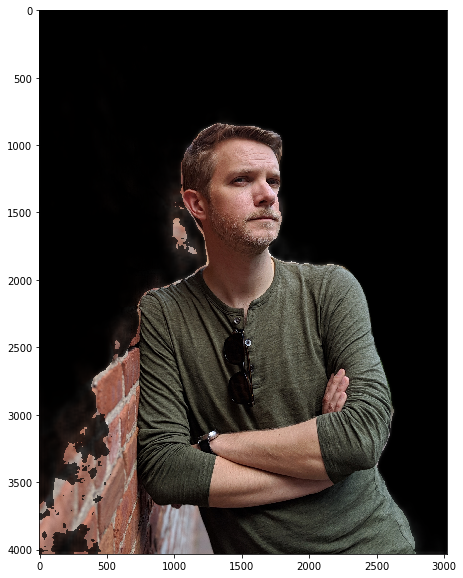

In [12]:
import random
i = random.choice(range(0,len(fnames)))
im = np.copy(images[i])
mask = skimage.transform.resize(outs[i],im.shape[:2],preserve_range=True)
mask[mask>0.3]=1
im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), im.astype(float))/255
#im[mask<0.3]=0
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(im)